In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cvxpy
import math
import numpy as np

#import cubic_spline_planner


NX = 4  # x = x, y, v, yaw
NU = 2  # a = [accel, steer]
T = 5  # horizon length

# mpc parameters
R = np.diag([0.01, 0.01])  # input cost matrix
Rd = np.diag([0.01, 1.0])  # input difference cost matrix
Q = np.diag([1.0, 1.0, 0.5, 10])  # state cost matrix
Qf = Q  # state final matrix

GOAL_DIS = 1.5  # goal distance
STOP_SPEED = 0.5 / 3.6  # stop speed
MAX_TIME = 500.0  # max simulation time

# iterative paramter
MAX_ITER = 3  # Max iteration
DU_TH = 0.1  # iteration finish param

TARGET_SPEED = 15#10.0 / 3.6  # [m/s] target speed
N_IND_SEARCH = 10  # Search index number

DT = 0.2  # [s] time tick

# Vehicle parameters
WB = 110#2.5  # [m]

MAX_STEER = np.deg2rad(45.0)  # maximum steering angle [rad]
MAX_DSTEER = np.deg2rad(30.0)  # maximum steering speed [rad/s]
MAX_SPEED = 25#55.0 / 3.6  # maximum speed [m/s]
MIN_SPEED = -25#-20.0 / 3.6  # minimum speed [m/s]
MAX_ACCEL = 5.0  # maximum accel [m/ss]

show_animation = True

In [ ]:
import tensorflow as tf

In [3]:
def iterative_linear_mpc_control(xref, Motion_Status, dref, oa, od):
    """
    MPC contorl with updating operational point iteraitvely
    """  
    
    if oa is None or od is None:
        oa = [0.0] * T
        od = [0.0] * T
    state=Motion_Status.get_state()   
    for i in range(MAX_ITER):
        xbar = Motion_Status.get_trajectory(oa, od,T)
        poa, pod = oa[:], od[:]
        oa, od, ox, oy, oyaw, ov = linear_mpc_control(xref, xbar, state, od)
        du = sum(abs(oa - poa)) + sum(abs(od - pod))  # calc u change value
        if du <= DU_TH:
            break
    else:
        print("Iterative is max iter")
    
    return oa, od, ox, oy, oyaw, ov,xbar

def get_linear_model_matrix(v, phi, delta):
    A = np.zeros((NX, NX))
    A[0, 0] = 1.0
    A[1, 1] = 1.0
    A[2, 2] = 1.0
    A[3, 3] = 1.0
    A[0, 2] = DT * math.cos(phi)
    A[0, 3] = - DT * v * math.sin(phi)#
    A[1, 2] = DT * math.sin(phi)
    A[1, 3] = DT * v * math.cos(phi)#
    A[3, 2] = DT * math.tan(delta) / WB

    B = np.zeros((NX, NU))
    B[2, 0] = DT
    B[3, 1] = DT * v / (WB * math.cos(delta) ** 2)#
    
    C = np.zeros(NX)
    C[0] = DT * v * math.sin(phi) * phi
    C[1] = - DT * v * math.cos(phi) * phi
    C[3] = - DT * v * delta / (WB * math.cos(delta) ** 2)
    #C = np.zeros(NX)
    return A, B, C
def tm(var):
    res=1
    for v in var:
       res=tf.multiply(res,v)
    return res
def _get_linear_model_matrix(v, phi, delta):
    A = np.zeros((NX, NX))
    A[0, 0] = 1.0
    A[1, 1] = 1.0
    A[2, 2] = 1.0
    A[3, 3] = 1.0
    A[0, 2] = tm([DT,tf.cos(phi)])
    A[0, 3] = tm([-DT ,v,tf.sin(phi)])#
    A[1, 2] = tm([DT , tf.sin(phi)])
    A[1, 3] = tm([DT ,v , tf.cos(phi)])#
    A[3, 2] = tm([DT ,tf.tan(delta), tf.truediv(1, WB)])

    B = np.zeros((NX, NU))
    B[2, 0] = DT
    B[3, 1] = tf.truediv(tm(DT , v) , tm([WB , tf.square(tf.cos(delta))]))#
    
    C = np.zeros(NX)
    #C[0] = tm(DT,tm(v,tm( tf.sin(phi), phi))))
    #C[1] = tm(- DT ,tm( v ,tm( math.cos(phi) , phi))))
    #C[3] = tm([- DT , v , tf.truedi delta / (WB * math.cos(delta) ** 2)
    #C = np.zeros(NX)
    return A, B, C

def linear_mpc_control(xref, xbar, state, dref):
    """
    linear mpc control

    xref: reference point
    xbar: operational point
    x0: initial state
    dref: reference steer angle
    """

    x = cvxpy.Variable((NX, T + 1))
    u = cvxpy.Variable((NU, T))

    cost = 0.0
    constraints = []

    for t in range(T):
        #cost += cvxpy.quad_form(u[:, t], R)
        cost += cvxpy.quad_form(u[:, t], R)

        if t != 0:
            cost += cvxpy.quad_form(xref[:, t] - x[:, t], Q)

        A, B, C = get_linear_model_matrix(xbar[2, t], xbar[3, t], dref[t])
        constraints += [x[:, t + 1] == A * x[:, t] + B * u[:, t]+ C]

        if t < (T - 1):
            cost += cvxpy.quad_form(u[:, t + 1] - u[:, t], Rd)
            constraints += [cvxpy.abs(u[1, t + 1] - u[1, t]) <=
                            MAX_DSTEER * DT]

    cost += cvxpy.quad_form(xref[:, T] - x[:, T], Qf)

    constraints += [x[:, 0] == [state.x,state.y,state.v,state.yaw]]
    constraints += [x[2, :] <= MAX_SPEED]
    constraints += [x[2, :] >= MIN_SPEED]
    constraints += [cvxpy.abs(u[0, :]) <= MAX_ACCEL]
    constraints += [cvxpy.abs(u[1, :]) <= MAX_STEER]

    prob = cvxpy.Problem(cvxpy.Minimize(cost), constraints)
    prob.solve(solver=cvxpy.OSQP, warm_start=True)
    #prob.solve(solver=cvxpy.ECOS, verbose=False)

    if prob.status == cvxpy.OPTIMAL or prob.status == cvxpy.OPTIMAL_INACCURATE:
        ox = np.array(x.value[0, :]).flatten()
        oy = np.array(x.value[1, :]).flatten()
        ov = np.array(x.value[2, :]).flatten()
        oyaw = np.array(x.value[3, :]).flatten()
        oa = np.array(u.value[0, :]).flatten()
        odelta = np.array(u.value[1, :]).flatten()

    else:
        print("Error: Cannot solve mpc..")
        oa, odelta, ox, oy, oyaw, ov = None, None, None, None, None, None

    return oa, odelta, ox, oy, oyaw, ov


In [4]:
class State:
     
    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.predelta = None

class Motion():

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.state=State(x=x, y=y, yaw=yaw, v=v)
        
    def get_state(self):
        return State(x=self.state.x, y=self.state.y, yaw=self.state.yaw, v=self.state.v)
        
    def set_state(self,state):
        self.state=state
    def get_next_state(self, a, delta, curr_state=-1):
        if curr_state==-1:
            curr_state=self.state
        # input check
        if delta >= MAX_STEER:
            delta = MAX_STEER
        elif delta <= -MAX_STEER:
            delta = -MAX_STEER

        next_x = curr_state.x + curr_state.v * math.cos(curr_state.yaw) * DT
        next_y = curr_state.y + curr_state.v * math.sin(curr_state.yaw) * DT
        next_yaw = curr_state.yaw + curr_state.v / WB * math.tan(delta) * DT
        next_v = curr_state.v + a * DT
        print(curr_state.v,a,DT,next_v)
        if next_v > MAX_SPEED:
            next_v = MAX_SPEED
        elif next_v < MIN_SPEED:
            next_v = MIN_SPEED

        return State(x=next_x,y=next_y,v=next_v,yaw=next_yaw)
    
    def _get_next_state(self, a, delta, curr_state=-1):
        if curr_state==-1:
            curr_state=self.state
        # input check
        if delta >= MAX_STEER:
            delta = MAX_STEER
        elif delta <= -MAX_STEER:
            delta = -MAX_STEER
            
        A, B, C = get_linear_model_matrix(curr_state.v, curr_state.yaw, delta)
        X=np.array([curr_state.x,curr_state.y,curr_state.v,curr_state.yaw],dtype=np.float64)
        U=np.array([a,delta],dtype=np.float64)
        [next_x,next_y,next_v,next_yaw]=np.matmul(A,X) + np.matmul(B,U)+ C
        
        
        if next_v > MAX_SPEED:
            next_v = MAX_SPEED
        elif next_v < MIN_SPEED:
            next_v = MIN_SPEED

        return State(x=next_x,y=next_y,v=next_v,yaw=next_yaw)


    def get_trajectory(self,accels, deltas,time_step):
        xbar =np.zeros((NX, time_step + 1))
        xbar[:, 0] = self.state.x,self.state.y,self.state.v,self.state.yaw
        #_state=State(x=state.x,y=state.y,v=state.v,yaw=state.yaw)
        _state=Motion.get_state(self)
        for (accel, delta, i) in zip(accels, deltas, range(1, T + 1)):
            next_state = Motion._get_next_state(self,accel, delta, curr_state=_state)
            xbar[:, i] = next_state.x,next_state.y,next_state.v,next_state.yaw
            _state=next_state
        

        return xbar


In [ ]:
import tensorflow as tf

class State:
     
    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.predelta = None
def tf_quad_form(_a,_b):
        _at=tf.transpose(_a)
        _res=tf.matmul(_at,_b)
        return tf.matmul(_res,_a)

def _linear_mpc_control(xref, xbar, state, dref):
    XX=np.zeros((NX,T+1),dtype=np.float64)
    UU=np.zeros((NU,T),dtype=np.float64)
    _ms=Motion()
    _ms.set_state(state)
    _xbar = _ms.get_trajectory(oa, od,T).copy()
    #tf.reset_default_graph()
    x=tf.Variable(XX,dtype=tf.float64,trainable=False,name='x')
    #xb=tf.Variable(_xbar,dtype=tf.float64,trainable=False,name='x')
    u = tf.Variable(UU,trainable=True,name='u')
    cost = tf.Variable(0.0,dtype=tf.float64,name='cost')    
    #xb=tf.placeholder((NX,T),dtype=tf.float64)
    xb=_xbar.copy()
    init_xt=x[:,0].assign(xb[:,0])
    ops=[init_xt]
    for t in range(T):
        u_t= tf.reshape(u[:, t],[2,1])
        cost= tf.add(cost, tf_quad_form(u_t, R))
        #ops.append(cost)
        x_t= tf.reshape(x[:, t],[4,1])
        xref_t= tf.reshape(xref[:, t],[4,1])

        A, B, C = get_linear_model_matrix(xb[2, t], xb[3, t], dref[t])
        
        A=tf.Variable(A,trainable=False,name='A')
        B=tf.Variable(B,trainable=False,name='B')
        C=tf.Variable(C,trainable=False,name='C')
        
        x_t1=tf.matmul(A,x_t) + tf.matmul(B,u_t) + tf.reshape(C,shape=[4,1])
        xref_t1= tf.reshape(xref[:, t+1],[4,1])
        cost= tf.add(cost,tf_quad_form(xref_t1 - x_t1 , Q))
        #ops.append(cost)
        
        asn_op=x[:,t+1].assign(tf.reshape(x_t1,[4]))
        ops.append(asn_op)
        
        if t < (T - 1):
            u_t1=tf.reshape(u[:,t+1],[2,1])
            #cost= tf.add(cost,tf_quad_form(u_t1 - u_t, Rd))
        
        
        
    x_T= tf.reshape(x[:, T],[4,1])
    xref_T= tf.reshape(xref[:, T],[1,4])
    cost = tf.add(cost,tf_quad_form(xref_t1 - x_t1, Qf))
    ops.append(cost)
    
    
    optm = tf.train.GradientDescentOptimizer(.1).minimize(cost)
    ops.append(optm)
    init = tf.global_variables_initializer()
    return ops,x,u,cost,init
_xref=np.ones((4,5+1),dtype=np.float64)
_xref[0,:]=5
_xref[1,:]=0
_xref[2,:]=5
_xref[3,:]=5
_dref=np.zeros((5),dtype=np.float64)
oa=[0]*5
od=[0]*5

tf.reset_default_graph()
with tf.Session() as sess:
            _state=State(x=0.0,y=0.0,yaw=0.0,v=1.0)
            _ms=Motion()
            _ms.set_state(_state)
            _xbar = _ms.get_trajectory(oa, od,T).copy()
            
            
            
            
            XX=[]
            UU=[]
            cost=[]
            
            _state=State(x=0.0,y=0.0,yaw=0.0,v=1.0)       
            _ops,_X,_U,_cost,init=_linear_mpc_control(_xref, _xbar, _state, _dref)
            sess.run(init)
            for i in range(1000):
                print(i)
                #writer = tf.summary.FileWriter('./graphs', sess.graph)
                for op in _ops:
                    ret=sess.run(op)
                #print(ret[1])
                X,U,cc=sess.run([_X,_U,_cost])
                x=X
                u=U
                oa=U[0]
                od=U[1]
                #_dref=U[1]
                np.set_printoptions(suppress=True)
                XX.append(X[:,-1])
                UU.append(U[:,-1])
                cost.append(cc)
            print('..............\n','\nu\n',U,'\nx\n',X)
            
                #print(ret3)
    
    #return ops,X,U,_cost,XX,UU
    #return oa, odelta, ox, oy, oyaw, ov


#!tensorboard --logdir="./graphs" --port 6006

In [87]:
ms=Motion()
ms.set_state(State(x=0.0,y=0.0,yaw=0.0,v=1))
#st=ms._get_next_state(9.61,0.15)
#st=ms.get_state()
#st.x,st.y,st.yaw,st.v
ret=iterative_linear_mpc_control(_xref, ms, _dref, [0]*5, [0]*5)
#print(st.yaw)
ret

(array([4.99999418, 4.99999529, 4.99999596, 4.7917783 , 1.29740481]),
 array([0.78548085, 0.7854815 , 0.78548025, 0.78548131, 0.78548055]),
 array([0.        , 0.2       , 0.5999991 , 1.19998975, 1.99994154,
        2.99144813]),
 array([-0.00000001, -0.00000006,  0.00072717,  0.00400008,  0.01272805,
         0.0307596 ]),
 array([-0.00000019,  0.00181811,  0.00545491,  0.01091019,  0.01818401,
         0.02720062]),
 array([0.99999999, 1.99999881, 2.99999786, 3.99999704, 4.95835268,
        5.21783363]),
 array([[0.        , 0.2       , 0.59999911, 1.19998976, 1.99994158,
         2.99144734],
        [0.        , 0.        , 0.00072727, 0.00399998, 0.01272707,
         0.03075642],
        [1.        , 1.99999884, 2.9999979 , 3.99999709, 4.95834835,
         5.21783279],
        [0.        , 0.00181818, 0.00545454, 0.01090908, 0.01818181,
         0.02719699]]))

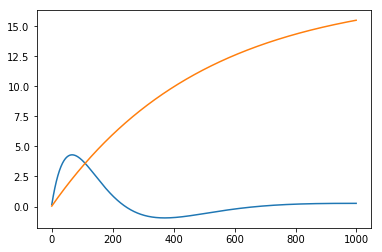

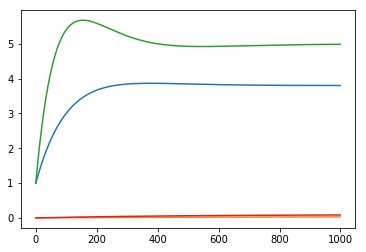

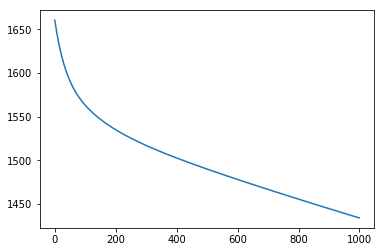

In [16]:
XX=np.array(XX)
UU=np.array(UU)
cost=np.array(cost)
plt.plot(UU)
plt.show()
plt.plot(XX)
plt.show()
plt.plot(cost.reshape(-1))
plt.show()
#_XX[10],_UU[10]
#cost

In [ ]:
import tensorflow as tf
import  numpy as np
a=tf.constant(np.ones((10),dtype=np.float64))
a=tf.ones((1),dtype=tf.float64)
ops=[]
for i in range(10):
    a1=tf.add(a,1)
    ops.append(a1)
    a=a1
    #_agn_op=a.assign(a1)
    #ops.append(_agn_op)
with tf.Session() as sess:
    _,ret=sess.run([ops,a1])
    print(ret)

In [27]:
tf.reset_default_graph()
a=tf.Variable(tf.ones((10),dtype=tf.float64),trainable=False)
ops=[]

for i in range(10):
    a1=tf.add(a,1)
    ops.append(a1)
    #a=a1
    _agn_op=a.assign(a1)
    ops.append(_agn_op)
_ops=tf.group(*ops,name='ops')
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    _=sess.run(_ops)
    ret=sess.run(a1)
    print(ret)

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


In [ ]:
!tensorboard --logdir="./graphs" --port 6006
#sess.graph
#!ls
#!mkdir graphs

W1021 12:03:50.672823 Reloader tf_logging.py:114] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W1021 12:03:50.673551 Reloader tf_logging.py:114] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
W1021 12:03:50.675085 Reloader tf_logging.py:114] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W1021 12:03:50.675360 Reloader tf_logging.py:114] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
W1021 12:03:50.676290 Reloader tf_logging.py:114] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W1021 12:03:50.676492 Reloader tf_logging.p

In [11]:
import tensorflow as tf

x = tf.Variable(10.0, trainable=True)
f_x = 2 * x* x - 5 *x + 4

loss = f_x
opt = tf.train.GradientDescentOptimizer(0.1).minimize(f_x)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100):
        print(sess.run([x,loss]))
        sess.run(opt)

[10.0, 154.0]
[6.5, 56.0]
[4.3999996, 20.719995]
[3.1399999, 8.019199]
[2.3839998, 3.4469109]
[1.9303999, 1.8008881]
[1.65824, 1.2083197]
[1.494944, 0.9949951]
[1.3969663, 0.9181981]
[1.3381798, 0.89055157]
[1.302908, 0.88059855]
[1.2817447, 0.8770151]
[1.2690468, 0.8757255]
[1.2614281, 0.87526155]
[1.2568569, 0.87509394]
[1.2541142, 0.87503386]
[1.2524685, 0.87501216]
[1.251481, 0.8750043]
[1.2508886, 0.87500143]
[1.2505331, 0.8750005]
[1.2503198, 0.875]
[1.2501919, 0.87500024]
[1.2501152, 0.87499976]
[1.2500691, 0.875]
[1.2500415, 0.875]
[1.2500249, 0.87500024]
[1.2500149, 0.87500024]
[1.250009, 0.875]
[1.2500054, 0.87500024]
[1.2500032, 0.875]
[1.2500019, 0.875]
[1.2500012, 0.87500024]
[1.2500007, 0.87499976]
[1.2500005, 0.875]
[1.2500002, 0.87500024]
[1.2500001, 0.87500024]
[1.2500001, 0.87500024]
[1.2500001, 0.87500024]
[1.2500001, 0.87500024]
[1.2500001, 0.87500024]
[1.2500001, 0.87500024]
[1.2500001, 0.87500024]
[1.2500001, 0.87500024]
[1.2500001, 0.87500024]
[1.2500001, 0.87500

In [37]:
_xbar=np.ones((4,5),dtype=np.float64)
_xref=5*np.ones((4,5),dtype=np.float64)
_dref=5*np.ones((5),dtype=np.float64)
_state=State(x=0.0,y=0.0,yaw=0.0,v=0.0)
x = tf.zeros(dtype=tf.float64,shape=(NX, T + 1))
u = tf.zeros(dtype=tf.float64,shape=(NU, T))
t=0
A, B, C = get_linear_model_matrix(_xbar[2, t], _xbar[3, t], _dref[t])
#x[:, t + 1] =
dd=tf.matmul(A , tf.reshape(x[:, t],[4,1])) 
#ee= tf.matmul(B , tf.reshape(u[:, t],[2,1]))
#ff=C
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
ret1=sess.run([dd,ee])
ret1

[array([[0.],
        [0.],
        [0.],
        [0.]]), array([[0.],
        [0.],
        [0.],
        [0.]])]

In [4]:
from Car_Env import Car_Env
from Data_Processor import Data_Processor
from Car_Plot import Move_Contour,Draw_Car

In [5]:
#cx, cy, cyaw, ck = get_switch_back_course(dl)
dl=1.0
rec=False
max_len=350
qlen=25
car_move=True
Env=Car_Env(rec=rec,max_len=max_len,qlen=qlen)
[init_state,map_points]=Env.reset()
mpx=np.array(map_points[:max_len,0])#-ofx
mpy=np.array(map_points[:max_len,1])#-ofy
ix,iy,iyaw,ivel=init_state[0]
_traj=init_state[1][0]
_dind=init_state[1][1]
_end=init_state[1][2]
ofx,ofy,ofang=init_state[2]
img=init_state[3]
Motion_Status = Motion(x=ix, y=iy, yaw=iyaw, v=ivel)
state=Motion_Status.get_state()
#print(init_state)

Track generation: 1224..1534 -> 310-tiles track


In [6]:
if rec==True:
    import os
    if not os.path.exists('Rec/'):
        os.mkdir('Rec')
    if not os.path.exists('Fig/'):
        os.mkdir('Fig')


In [7]:
import matplotlib.gridspec as gridspec
phi=0
rot_mat=np.array([[math.cos(phi),math.sin(phi)],[-math.sin(phi),math.cos(phi)]])
time = 0.0
x = [state.x]
y = [state.y]
yaw = [state.yaw]
v = [state.v]
t = [0.0]
d = [0.0]
a = [0.0]

log_state=[]
log_traj=[]
log_img=[]
log_act=[]
log_next_state=[]


#index, _ = get_closest_point(state, _cx, _cy, cyaw, 0)
odelta, oa = None, None
_index=0
#cyaw = smooth_yaw(cyaw)
accl,gas,steer=0,0,0
state_str=''
act_str=''
xref_str=''
xbar_str=''


_Data_Processor=Data_Processor(_speed=TARGET_SPEED,tlen=qlen)
acc_st=State(x=0,y=0)
itr=0
#fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
fig=plt.figure(figsize=(10,10))
gs = fig.add_gridspec(3, 1)
ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1:,:])
axes=[ax1,ax2]


def map_plot(vect,_ofx,_ofy,_ofang):
    _vect=np.array(vect,dtype=np.float64).copy()
    _ofang=-1*_ofang
    rot_mat=np.array([[math.cos(_ofang),math.sin(_ofang)],[-math.sin(_ofang),math.cos(_ofang)]])
    _vect=np.matmul(rot_mat,_vect)

    _vect[0]+=_ofx
    _vect[1]+=_ofy
    return [_vect[0],_vect[1]]
def inv_map_plot(vect,_ofx,_ofy,_ofang):
    _vect=np.array(vect,dtype=np.float64).copy()
    _vect[0]-=_ofx
    _vect[1]-=_ofy
    _ofang=1*_ofang
    rot_mat=np.array([[math.cos(_ofang),math.sin(_ofang)],[-math.sin(_ofang),math.cos(_ofang)]])
    _vect=np.matmul(rot_mat,_vect)
    return [_vect[0],_vect[1]]

while MAX_TIME >= time:
        state=Motion_Status.get_state()
        _full_state = [state.x, state.y, state.v, state.yaw]
    
        
        _full_state_traj=_Data_Processor.update_trajectory(_traj)
        xref, dref = _Data_Processor.get_ref_trajectory(state,dl,DT,T)
        
        if _end==True:
            break

        _index+=_dind
        
        oa, odelta, ox, oy, oyaw, ov ,xbar= iterative_linear_mpc_control(xref, Motion_Status, dref, oa, odelta)
        
        state_str=str(state.x)+','+str(state.y)+','+str(state.v)+','+str(np.rad2deg(state.yaw))+'\n'
        xref_str=str(xref[0][0])+','+str(xref[1][0])+','+str(xref[2][0])+','+str(np.rad2deg(xref[3][0]))+','+str(_index)+'\n'
        xbar_str=str(xbar[0][0])+','+str(xbar[1][0])+','+str(xbar[2][0])+','+str(np.rad2deg(xbar[3][0]))+'\n'
        act_str=str(accl)+','+str(gas)+','+str(np.rad2deg(steer))+'\n'
    
        #xref_str=str(xref[3][0])+'\n'
        #xbar_str=str(xbar[3][:])+'\n'
        if odelta is not None:
            di, ai = odelta[0], oa[0]
        accl=ai
        steer=di
        
        #act_str=str(steer)+'\n'
        nst,path,offset,img,rw,ter,info=Env.step([steer,accl,0])
        _traj,_dind,_end=path
        ofx,ofy,ofang=offset
        
        gas=Env.gas
        
        next_state=State(x=nst[0],y=nst[1],yaw=nst[2],v=nst[3])
        Motion_Status.set_state(next_state)
        
        log_state.append(_full_state)
        log_traj.append(_full_state_traj)
        log_img.append(img)
        log_act.append([accl,steer,0])
        log_next_state.append(next_state)
        
        time = time + DT
        if car_move==True:
            _xref=xref.copy()
            [_ox,_oy]=map_plot([ox,oy],ofx,ofy,ofang)
            [_xref[0,:],_xref[1,:]]=map_plot([xref[0,:],xref[1,:]],ofx,ofy,ofang)
            [_x,_y]=map_plot([state.x,state.y],ofx,ofy,ofang)
            car_x,car_y,car_ang=ofx,ofy,ofang
            _mpx,_mpy=mpx,mpy
        else:
            _ox,_oy=ox,oy
            _xref=xref
            _x,_y=state.x,state.y
            car_x,car_y,car_ang=state.x,state.y,state.yaw
            [_mpx,_mpy]=inv_map_plot([mpx,mpy],ofx,ofy,ofang)
        x.append(_x)
        y.append(_y)
        yaw.append(ofang)
        v.append(state.v)
        t.append(time)
        d.append(di)
        a.append(ai)

        
    
      
        
        if show_animation:  # pragma: no cover
            axes[0].cla()
            axes[1].cla()
            axes[0].text(.01,.6,'state : '+state_str,fontsize=10,color='r')
            axes[0].text(.01,.4,'xref : '+xref_str,fontsize=10,color='b')
            axes[0].text(.01,.2,'xbar : '+xbar_str,fontsize=10,color='c')
            axes[0].text(.01,0,'act : '+act_str,fontsize=10,color='g')
            
            if ox is not None:
                axes[1].plot(_ox, _oy, "xr", label="MPC",alpha=1.0)
            axes[1].plot(_mpx, _mpy, "-b", label="course")
            axes[1].plot(x, y, "oc", label="trajectory")
            axes[1].plot(_xref[0, :], _xref[1, :], "xk", label="xref",alpha=1.0)
            axes[1].plot(_mpx[_index], _mpy[_index], "xg", label="target",alpha=1.0)
            #plot_car(state.x, state.y, state.yaw, steer=di)
            
            car_points=Draw_Car(car_x,car_y)
            rp=Move_Contour(car_points,0,0,car_ang)
            r_car_points=rp.apply()
            r_points=np.array(r_car_points,dtype=np.float64)
            axes[1].plot(r_points[:,0].flatten(),r_points[:,1].flatten(),"-r")
            
            plt.axis("equal")
            plt.grid(True)
            #plt.title("Time[s]:" + str(round(time, 2))
            #          + ", speed[km/h]:" + str(round(state.v * 3.6, 2))
            #          + '\nyaw'+str(state.yaw)
            #          + '\nxref_yaw'+str(xref[3][0])
            #          + '\nsteer'+str(steer))
            #fig.canvas.draw()
            plt.pause(0.0001)
            if itr%25==0:
                plt.savefig('Fig/'+str(int(itr/25))+'.jpg')
            itr+=1
if show_animation:  # pragma: no cover
            plt.close("all")
            plt.subplots()
            plt.plot(cx, cy, "-r", label="spline")
            plt.plot(x, y, "-g", label="tracking")
            plt.grid(True)
            plt.axis("equal")
            plt.xlabel("x[m]")
            plt.ylabel("y[m]")
            plt.legend()

            plt.subplots()
            plt.plot(t, v, "-r", label="speed")
            plt.grid(True)
            plt.xlabel("Time [s]")
            plt.ylabel("Speed [kmh]")

            plt.show()


DCPError: Problem does not follow DCP rules.

In [ ]:
log_dict={
'state':log_state,
'traj':log_traj,
'image':log_img,
'action':log_act,
'next_sate':log_next_state
}

In [ ]:
f=open('dataset','rb')
dataset=pickle.load(f)
f.close()f.close()

In [ ]:
ofx,ofy

In [ ]:
np.arctan2(1,1)

In [ ]:
#%matplotlib inline
plt.plot(cx,cy)
plt.show()

In [ ]:
plt.plot(range(len(cyaw)),cyaw)
plt.show()

In [ ]:
dcx=np.gradient(cx)
dcy=np.gradient(cy)
cyaw=[np.arctan2(y,x) for x,y in zip(dcx,dcy)]

In [ ]:
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(tx,ty,ds=dl)
yaw0=np.deg2rad(90)
cyaw=[yaw-yaw0 for yaw in cyaw]

In [ ]:
import numpy as np
np.rad2deg(2.64)

In [ ]:
cyaw

In [ ]:
import cvxpy as cp
import numpy as np

# Problem data.
m = 1
n = 1
np.random.seed(1)
A = 10#np.random.randn(m, n)
b = 5#np.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A*x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(x.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

In [ ]:
print(x.value)

In [ ]:
x=np.array(range(0,100))
x=x/100

In [ ]:
y=10*x-5
y=np.square(y)
plt.plot(x,y)
plt.show()

In [ ]:
import gym
gym.make('CarRacing-v0')